<a href="https://colab.research.google.com/github/zctpig/Caltech-UCSD-Birds-200-2011/blob/master/%E2%80%9Cpytorch_caltech_birds_classification_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Test Split

In [1]:
!pip install scikit-image==0.14.3

     |████████████████████████████████| 25.4MB 1.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.15.0
    Uninstalling scikit-image-0.15.0:
      Successfully uninstalled scikit-image-0.15.0


In [2]:
import skimage
print(skimage.__version__)

0.14.3


In [3]:
!wget --no-check-certificate \
    http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-08-23 07:04:45--  http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150585339 (1.1G) [application/x-tar]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]   1.07G  7.22MB/s    in 2m 28s  

2019-08-23 07:07:13 (7.42 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [1150585339/1150585339]



In [0]:
!tar -zxf /tmp/cats_and_dogs_filtered.zip -C /tmp/

In [0]:
PATH = '/tmp/CUB_200_2011/'

In [0]:
read_line = open(PATH + 'train_test_split.txt')

In [0]:
a = read_line.readlines()

In [8]:
a[0].split(' ')[1].split('\n')[0]

'0'

In [9]:

classes = open(PATH + 'classes.txt')
c_names = classes.readlines()
len(c_names)

200

In [0]:
for i in range(len(c_names)):
    c_names[i] = c_names[i].split(' ')[1]

In [11]:
c_names[0].split('\n')[0]

'001.Black_footed_Albatross'

In [0]:
import os
for i in range(len(c_names)):
    dir_name = PATH + 'test/' + c_names[i].split('\n')[0]
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [0]:
for i in range(len(c_names)):
    dir_name = PATH + 'train/' + c_names[i].split('\n')[0]
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [0]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import torch.utils.data as data
from torchvision import datasets, models, transforms

In [0]:
train_dataset = datasets.ImageFolder(PATH + 'images')

In [0]:
from skimage import io

In [17]:
print(len(train_dataset.imgs))

11788


In [0]:
for j in range(len(train_dataset.imgs)):
    if(a[j].split(' ')[1].split('\n')[0] == '0'):
        path = train_dataset.imgs[j][0]
        img = io.imread(path)
        folder = train_dataset.imgs[j][0][9:].split('/')[-2]
        img_name = train_dataset.imgs[j][0][9:].split('/')[-1]
        io.imsave(PATH + 'test/' + folder + '/' + img_name, img)
        os.remove(path)
    else:
        path = train_dataset.imgs[j][0]
        img = io.imread(path)
        folder = train_dataset.imgs[j][0][9:].split('/')[-2]
        img_name = train_dataset.imgs[j][0][9:].split('/')[-1]
        io.imsave(PATH + 'train/' + folder + '/' + img_name, img)
        os.remove(path)

In [19]:
total = 0
for path, dirs, files in os.walk(PATH + 'train'):
    total += len(files)
print('train images number:', total)

train images number: 5994


In [20]:
total = 0
for path, dirs, files in os.walk(PATH + 'test'):
    total += len(files)
print('test images number:', total)

test images number: 5794


# Model

In [0]:
# here are the necessary imports
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
plt.ion()

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [23]:
dataset_sizes

{'test': 5794, 'train': 5994}

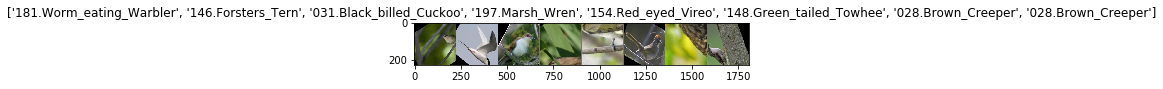

In [24]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [25]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
G_DRIVE = '/gdrive/My Drive/'

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                print(scheduler.get_lr())
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                torch.save(state, G_DRIVE + 'point_resnet_best.pth')
            
            if phase == 'train':
                scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloders['test']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [0]:
model_ft = models.resnet50(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 200 categories
 
if use_gpu:                                 # if gpu is available then use it
    model_ft = model_ft.cuda()       
# model_ft = model_ft.float()
criterion = nn.CrossEntropyLoss()           # defining loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters())

In [0]:
if os.path.exists(G_DRIVE + 'point_resnet_best.pth'):
    checkpoint = torch.load(G_DRIVE + 'point_resnet_best.pth')
    model_ft.load_state_dict(checkpoint['model'])
    optimizer_ft.load_state_dict(checkpoint['optim'])

In [0]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, 30, gamma=0.1, last_epoch=-1)

In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=90)

train Loss: 0.6697 Acc: 0.0065
test Loss: 0.6317 Acc: 0.0174

Epoch 1/89
----------
[0.01]
train Loss: 0.6257 Acc: 0.0199
test Loss: 0.6294 Acc: 0.0333

Epoch 2/89
----------
[0.01]
train Loss: 0.5848 Acc: 0.0367
test Loss: 0.5398 Acc: 0.0828

Epoch 3/89
----------
[0.01]
train Loss: 0.5471 Acc: 0.0607
test Loss: 0.5182 Acc: 0.0991

Epoch 4/89
----------
[0.01]
train Loss: 0.5059 Acc: 0.1021
test Loss: 0.4442 Acc: 0.1702

Epoch 5/89
----------
[0.01]
train Loss: 0.4854 Acc: 0.1243
test Loss: 0.5082 Acc: 0.1738

Epoch 6/89
----------
[0.01]
train Loss: 0.4510 Acc: 0.1693
test Loss: 0.3853 Acc: 0.2440

Epoch 7/89
----------
[0.01]
train Loss: 0.4270 Acc: 0.1947
test Loss: 0.4038 Acc: 0.2610

Epoch 8/89
----------
[0.01]
train Loss: 0.4017 Acc: 0.2379
test Loss: 0.3658 Acc: 0.3165

Epoch 9/89
----------
[0.01]
train Loss: 0.3754 Acc: 0.2744
test Loss: 0.3836 Acc: 0.3240

Epoch 10/89
----------
[0.01]
train Loss: 0.3611 Acc: 0.2965
test Loss: 0.2932 Acc: 0.4004

Epoch 11/89
----------
[0.0

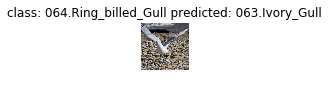

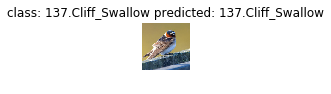

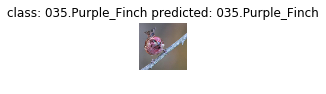

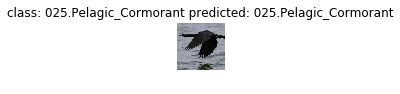

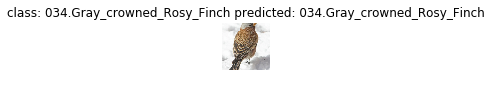

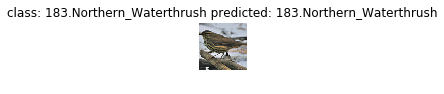

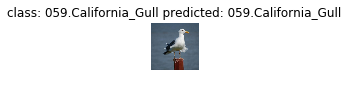

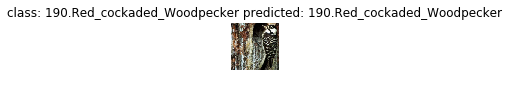

In [33]:
visualize_model(model_ft)

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [0]:
def calc_accuracy(model, data):
    model.eval()
    if use_gpu:
        model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloders[data]):
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        prec1, prec5 = accuracy(outputs, Variable(labels), topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5
    
top1 ,top5 = calc_accuracy(model_ft, 'test')

In [37]:
top1.avg

tensor(74.5599, device='cuda:0')

In [38]:
top5.avg

tensor(93.2344, device='cuda:0')